# Dynamic Programming Approach to Leniency Policies in Collusive Corruption



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
import scipy.sparse as sparse
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP
%load_ext itikz

## The Basic Model - Cumulated Liability and Absence of Leniency

Given the following constants for all periods $t$:

 1) Let $b$ be the price from the bribe and $\pi$ the rent extracted from contracts;
 
 2) Let $\alpha$ be the probability of being detected, and if so, convicted with probability $\beta$;
 
 3) Let $\delta \in [0,1] $ be the time discount; 
 
 4) Let $D$ be the interest over the assets $A$;
 
 5) Let $d$ be the decay over the judicial liabilities $L$; and
 
 6) Lastly, let $\eta$ be a relative risk aversion coefficient.
  

In [2]:
#Structural Constants

pi = 4  #rent from the contract
b = 2   #Bribe
d = 1    #Decayment from the liability  
D = 1.2  #Interest over Asset
delta = 0.9  #time discount
eta = 0.5

#Probabilities

alpha = 0.08
beta = 0.60
# gamma = 0.05  #try different probabilities for desistence and corrupion


The state variables $\textbf{x}$ are:

    1) The wealth or the assets $A$ that the agent hold, measured in consumption units;
    2) The liability $L$ which is a function of the criminal history $C$ from the agent, measured in number of crimes; and
    3) The state of the world $S$ in which the agent can be.
  
The actions or controls $\textbf{u}$ are:

    1) The number of consumption units $a$ an agent can save; and
    2) Wheater to pay a bribe $b$ or not.
    
The figure bellow shows how the state of the world $s \in S$ change depending on the bribe decisions $\theta$ and the probabilities $\alpha$ and $beta$:

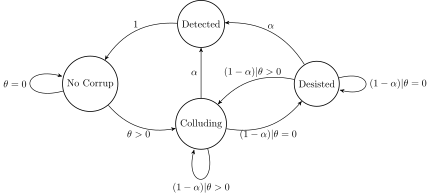

In [3]:
%%itikz
\documentclass[tikz]{standalone}
\begin{document}


\usetikzlibrary{decorations.pathreplacing,angles,quotes,calc,positioning,plotmarks}
\usetikzlibrary{shapes.geometric, arrows, automata,arrows,positioning,calc}
\tikzstyle{startstop} = [rectangle, rounded corners, minimum width=3cm, minimum height=1cm,text centered, draw=black]
\tikzstyle{io} = [trapezium, trapezium left angle=70, trapezium right angle=110, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{process} = [rectangle, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{decision} = [diamond, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{arrow} = [thick,->,>=stealth]

 	\begin{tikzpicture}[->, >=stealth', auto, semithick, node distance=2cm]
 		\tikzstyle{every state}=[fill=white,draw=black,thick,text=black,scale=1]
 		\node[state]    (B)        		       {No Corrup};
 		\node[state]    (D)[above right of= B]  at (2.5,0.7)	     	 {Detected};
 		\node[state]    (A)[below right of= B]	at (2.5,0)	         {Colluding};
 		\node[state]    (C)[right of= B]  at (6,0)				 { Desisted };
 		\path
 		(B) edge[loop left, left]	         node{$\theta=0$}              (B)
 		(B) edge[bend right,below]    			 node{$\theta>0$}        		(A)
 		(A) edge[loop below]    			 node{$(1-\alpha)|\theta>0$}            	(A)
 		(A) edge                			 node{$\alpha$}              (D)
 		(D) edge[bend right,above]   	 			 node{$1$}            	(B)
 		(A) edge [bend right,below]                node{$(1-\alpha)|\theta=0$}              (C)
 		(C) edge [bend right,above]                node{$(1-\alpha)|\theta>0$}              (A)
 		(C) edge[loop right]	         node{$(1-\alpha)|\theta=0$}             (C)
 		(C) edge[bend right,above]    			 node{$\alpha$}            	(D);
 	\end{tikzpicture}
\end{document}


The state-spaces from $\textbf{x}$ are:

$A = [0,...,\bar{A}]$,
$L = [0,...,\bar{L}]$, and
$S = [s_{nc},s_{c},s_{des},s_{detA},s_{detC}]$.

The control or action-spaces from $\textbf{u}$ are:

$\theta = [0,b]$, and
$a = [0,...,\bar{a}]$.

In [4]:
# State Variables and Constants

A_bar = 10
A_space = np.arange(0,A_bar + 1,1) #Asset state space

L_bar = 5
L_space = np.arange(0,L_bar + 1,1) #Loability state space

s_nc = [1,0,0,0,0]
s_c = [0,1,0,0,0]
s_des = [0,0,1,0,0]
s_detC = [0,0,0,1,0]
s_detA = [0,0,0,0,1]

S = [s_nc, s_c , s_des , s_detC , s_detA]

#Action Space 
a_bar = A_bar
a_space = np.arange(0,a_bar + 1,1) #saving
theta_space = [0,b] #Payment of the bribe  (if o or 1 change the Reward function)

The agents problem is:

\begin{equation}
\max E_0 \sum_{t=0}^{\infty} \delta^t u(c_t)
\label{a1}
\end{equation}


$$\textrm{s.t.  } A_{t+1}  = D(A_t-c_t-\theta_t +y_t)$$

$$L_{t+1}  = d (L_t + C_t)$$

.


So the constraint functions are:

For $y = [0,\pi,F]$ let,

$y_{t}(s,L) = \begin{cases}
	0\textrm{   if not colluding}\\
	\pi \textrm{   if colluding}\\
	0\textrm{   if desisted} \\
	 F(L_t)\textrm{   if Convicted } \\
	0 \textrm{ if Acquitted } 
	\end{cases}$, 

and,

$C_{t}(s) = \begin{cases}
	1 \textrm{   if colluding and } L_{t-1} < \bar{L} \\
	-1 \textrm{   if desisted and }L_{t-1} > 0 \\
    0 \textrm{  else}\end{cases}$,
    
so,

$A_t =\displaystyle \frac{A_{t-1}}{D}$, and

$L_t(s) = C_{t} + d(L_{t-1})$ if $L_{t-1} < \bar{L}$ and $L_t=0$ if $s=s_{nc}$.

And the reward function is:

$u(c) = ln (c)$

$r(x,a) = ln (A + y(s,L) - a - \theta)$



In [5]:
#Functions:

#Future State Functions  
def L_prime(theta,L,d,s_prime):
    if s_prime == s_nc: # after detection goes back to zero
        return  0
    else:
        if theta == 0:
            if s_prime == s_des:
                if L > 0: #cannot be less than zero
                    return L - 1 #If there is liability then it desapears after each t of desistence
                else:
                    return 0 # up to no liability (The particular case in which agent is detected with no liability the fine is 0)
            else: # remains only the states in which the agent is detected
                return L
        else: # paid the bribe last period and the states are not desiste or not corrupting
            return min((int(1 + L)*d) , L_bar) #apply bondries (L_bar , 1) 

    
def A_prime(a, D): # For now lets make it simple ##Asset remuneration scheme ## Make a nicer function given A_bar
        return min(int((a+1)*D),A_bar) # always have at least 1 consumption unit to get the game going

def S_prime(s,theta):  #Describe the corruption dynamics (return boleans)
    if s == s_detA or s == s_detC:
        return s_nc
    elif theta == 0:
        if s == s_nc:
            return s_nc
        elif s == s_des or s== s_c:
            return s_des or s_detA or s_detC
    else:
        return s_c or s_detA or s_detC
    
#Present Output Functions

def F(A, pi, L): #Function Fine
    return min(A,pi*L*2) #Fines cannot be Bigger than the agents total Assets at t
                 #agents pay at most their total wealth = A - beckerian fine

def y(A, s ,L): #Output function
    if s == s_c:
        return pi
    elif s == s_detC:
        return - F(A, pi,L) 
    else:
        return 0
        
#Reward function
def r(A,L,s,a,theta):
    if A - a - theta + y(A,s,L) < 0: #does not appear in the feasible set
        return - np.inf
    if A - a - theta + y(A,s,L) == 0: #necessary because log(0)= indef
        return 0
    else:
        return (((A - a - theta + y(A,s,L))**(1-nu))-1)/(1-nu) #CRRA function
    
nu = 0.5

The state vector space (Also not feasible) $X(x) = \{[A = 0 , S= s_{nc} , L=0],...,[A= \bar{A} ,S=  s_{nc} , L=0 ],[A = 0 ,S =  s_{c} , L=0],...,[A = \bar{A} ,S = s_{c} ,L=0], ...[A = \bar{A} ,A =  s_{detC} , L=0],...,[\bar{A} , s_{detC} , \bar{L}]   \}$

The verctor space has size $n = n_A n_S n_L$, where $n_i$ is the number of possible elements in a state or action.

The action or control space $U(x) = \{ [a = 0 , \theta = 0], ... , [a = \bar{a}, \theta = 0],[a = 0 , \theta = b], ... , [a = \bar{a}, \theta = b] \}$.

The control space has dimension $ m = n_a n_\theta = 2 n_a$. 


In [6]:
# #Full States Space UNCOMMENT FOR USING FULL SPACES AND SPARCE MATRICES
# X = []

# for i in A_space:
#     for j in L_space:
#         for k in S:
#             X.append([i,j,k])
# len(X)




In [7]:
# #Full Action Space UNCOMMENT FOR USING FULL SPACES AND SPARCE MATRICES
# U = []

# for i in a_space:
#     for j in theta_space:
#         U.append([i,j])
        
# len(U)


In [8]:
# #Space Action Spcae:  UNCOMMENT FOR USING FULL SPACES AND SPARCE MATRICES

# XU = []

# for i in range(len(X)):
#     for j in range(len(U)):
#         XU.append([X[i][0],X[i][1],X[i][2],U[j][0],U[j][1]]) 
# len(XU)

### Dimension Reduction:

Instead of working with the entire space of controls and states. One can reduce the number of states only to possible movements, so the matrices decrease in dimension.

In [9]:
#Feasible Action Space J(x):
#Set of actions allowed for each state x in X
#Dimension Reduction 

X_feasible = [] #set of feasible states corresponding to the action
U_feasible = [] #set of feasible actions corresponding to the space
XU_feasible = [] #creat the vector of the state action pair (for conference)
for i in A_space:
    for j in L_space:
        for k in S:
            for m in a_space:
                for l in theta_space: #buget constraint and state impossibilities:
                    if  k == s_nc and j !=0:  #If the state is not colluding, the Liability will always be zero
                        pass
                    elif k == s_c and j == 0: #Agents will always have at least 1 liability if corruptiong
                        pass
                    elif k == s_detA and l == b: #Agents Cannot Bribe when detected
                        pass
                    elif k == s_detC and l == b: 
                        pass
                    elif i + y(i,k,j) - l < m:  #There must be funds to save
                        pass
                    elif i + y(i,k,j) - m < l:  #There must be funds to bribe
                        pass
                    else:
                        X_feasible.append([i,j,k])
                        U_feasible.append([m,l])
                        XU_feasible.append([i,j,k,m,l])
l = len(X_feasible)
l

2222

In [10]:
#Calculating the indexes (can be done also with pandas.DataFrame.loc[])

#The indices are important to identificate which state when analysing the policy functions

X_indices = [] # It creates an indice or name to each unique state in the list of feasible states

X = [] #new X space, only with feasible states

X_map =[[0,[X_feasible[0][0],X_feasible[0][1],X_feasible[0][2]]]] # Creates a map that identificate each state in Omega [i].

for i in range(len(X_feasible)):
    if X_feasible[i] == X_feasible[0]:
        X_indices.append(0)
        X =[[X_feasible[0][0],X_feasible[0][1],X_feasible[0][2]]]
    elif X_feasible[i] != X_feasible[i-1]:
        X_indices.append(X_indices[-1]+1)
        X_map.append([X_indices[i],[X_feasible[i][0],X_feasible[i][1],X_feasible[i][2]]])
        X.append(X_feasible[i])
    else:
        X_indices.append(X_indices[-1])


U_indices = [] # It creates an indice or name to each unique action in the list of feasible actions


for i in range(len(U_feasible)):
    if U_feasible[i] == U_feasible[0]:
        U_indices.append(0)
    elif U_feasible[i] != U_feasible[i-1]:
        U_indices.append(U_indices[-1]+1)
    else:
        U_indices.append(U_indices[-1])
        
        
n = len(X) #Number of feasible spaces



Generating the reward vector $R(\textbf{x},\textbf{u})$, of dimension $n \times m$ and the transition matrix $\Omega(\textbf{x},\textbf{u},\textbf{x}')$, of dimension $n \times m \times n$.

$R(\textbf{x},\textbf{u}) =  \begin{bmatrix}
r(X_0,U_0) & \cdots & r(X_0,U_m)\\
\vdots & \ddots & \vdots\\
r(X_n,U_0) & \cdots & r(X_n,U_m) \end{bmatrix}$

where $X_i$ and $U_j$ are the elements from the state and control space, where $i \in [0,n]$ and $j \in [0,m]$. Also,

$\Omega(\textbf{x},\textbf{u},\textbf{x}') = \begin{bmatrix}
 \begin{bmatrix}
p(X_0'|X_0,U_0) & \cdots & p(X_0'|X_0,U_m)\\
\vdots & \ddots & \vdots\\
p(X_0'|X_n,U_0) & \cdots & p(X_0'|X_n,U_m) \end{bmatrix} \\
\vdots \\
\begin{bmatrix}
p(X_n'|X_0,U_0) & \cdots & p(X_n'|X_0,U_m)\\
\vdots & \ddots & \vdots\\
p(X_n'|X_n,U_0) & \cdots & p(X_n'|X_n,U_m) \end{bmatrix} \end{bmatrix}$


In [11]:
#UNCOMENT FOR USING FULL SPARCE MATRIX
# #R(x,u) vector maps the statespace into rewards r

# #Create a Matrix (n x m)
# R = np.zeros((n,m))

# #Populate the Matrix
# for i in range(len(X)):
#     for j in range(len(U)):
#         R[i, j] = r(X[i][0],X[i][1],X[i][2],U[j][0],U[j][1]) 


In [12]:
#UNCOMMENT FOR USING FULL TRANSITION MATRIX
# Transition Matrix

# #Creat a Matrix (n x m x m)

# Omega = np.zeros((n,m,n))

# #Populate the Omega matrix with the probabilities of the future state given the current state
# for k in range(len(X)):
#     for i in range(len(X)):
#         for j in range(len(U)):
#             if X[k][0] == A_prime(U[j][0],D):  #State A' is feasible from an action 'a'
#                 if X[k][1] == L_prime(C(X[i][2]),X[i][1],d): #State L' is feasible from current states 's' and 'L'
#                     if U[j][1]==0: # if there is no bribe paid, the transition is deterministic
#                         Omega[i,j,k] = 1
#                     elif X[k][2]==s_c or s_des: # the states can only be reached a bribe is paid and the crime was not detected
#                         Omega[i,j,k] = 1-alpha
#                     elif x[k][2]==s_detA:
#                         Omega[i,j,k] = alpha*(1-beta)
#                     elif x[k][2]==s_detC:
#                         Omega[i,j,k] = alpha*beta
#                     else:
#                         Omega[i,j,k] = 0        
# len(Omega)

Once Again, it is possible to reduce the dimension from the matrices using only feasible states and actions:

In [13]:

R = []

for i in range(len(X_feasible)):
        R.append(r(X_feasible[i][0],X_feasible[i][1],X_feasible[i][2],U_feasible[i][0],U_feasible[i][1]))


In [14]:
#Transition Matrix

# #Creat a Matrix (l x n)

Omega = np.zeros((l,n))

#Populate the Omega matrix with the probabilities of the future state given the current state 

for i in range(l):
    for j in range(n):
            if X[j][0] == A_prime(U_feasible[i][0],D):  #State A' is feasible from an action a
                if X[j][1] == L_prime(U_feasible[i][1],X_feasible[i][1],d,X[j][2]): #State L' is feasible from current states 's' and 'L'
                    #if X[j][2] == S_prime(X_feasible[i][2],U_feasible[i][1]): #State s' must be feasible from the action pair (s,theta)
                        if (U_feasible[i][1]==0 and X_feasible[i][2] == s_nc) and X[j][2]==s_nc:
                            Omega[i,j] = 1
                        elif (X_feasible[i][2] == s_detA or X_feasible[i][2] == s_detC) and X[j][2]==s_nc: # if there is no bribe paid and no previous corruption, the transition is fully deterministic ## Future state is already defined in the S_prime function
                            Omega[i,j] = 1    
                        elif [U_feasible[i][1],X_feasible[i][2]] == [b,s_nc] and X[j][2] == s_c : # The case of start corruption and go ok
                            Omega[i,j] = 1-alpha
                        elif [U_feasible[i][1],X_feasible[i][2]] == [b,s_nc] and X[j][2] == s_detA : # The case of start corruption and detected but accquitted
                            Omega[i,j] = alpha*(1-beta)
                        elif [U_feasible[i][1],X_feasible[i][2]] == [b,s_nc] and X[j][2] == s_detC : # The case of start corruption goes bad
                            Omega[i,j] = alpha*beta
                        elif U_feasible[i][1] ==0 and (X_feasible[i][2]==s_des or X_feasible[i][2]== s_c) and X[j][2]==s_des : # the states can only be reached a bribe is paid and the crime was not detected
                            Omega[i,j] = 1-alpha
                        elif U_feasible[i][1] ==b and(X_feasible[i][2]==s_des or X_feasible[i][2]== s_c) and X[j][2]==s_c : # the states can only be reached a bribe is paid and the crime was not detected
                            Omega[i,j] = 1-alpha
                        elif (X_feasible[i][2]==s_des or X_feasible[i][2]== s_c) and X[j][2] == s_detA: # from previous corruprion to Accquitance
                            Omega[i,j] = alpha*(1-beta)
                        elif (X_feasible[i][2]==s_des or X_feasible[i][2]== s_c) and X[j][2] == s_detC: # from previous corruption to conviction
                            Omega[i,j] = alpha*beta
                        else:
                            Omega[i,j] = 0  
                            
test = []
fails = []
for i in range(len(Omega)):
    test.append(Omega[i].sum())
    if round(Omega[i].sum(),4) != 1:
        fails.append(i)
if len(fails) == 0:
    print('sucess: Omega shape', Omega.shape)
else:
    fails


#PS: Note that the number of conditions must equal the number of possible movements (arrows) in the Figure 1 + 1.

sucess: Omega shape (2222, 264)


In [15]:
# print('Example: From the state-action pair  XU_feasible[1000], or ', XU_feasible[1000],
#       ' there are positive probabilities of Omega[1000][253] = ', Omega[1000][253],', Omega[1000][254]=' ,
#       Omega[1000][254] ,', Omega[1000][259]= ',Omega[1000][259],
#      'to go to the states X[253] = ',X[253],', X[253] = ',X[254],', X[253] = ',X[259])

It is possible to rewrite the agent's problem as a value function, such as:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{u}} \{ u(\mathbf{x}) + \delta E[V(\mathbf{x'})|\mathbf{x},\mathbf{u}]\}$$

This is quivallento to:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{u}} \{ R(\mathbf{x},\mathbf{u}) + \delta V(\mathbf{x'}) \Omega(\mathbf{x'},\mathbf{u},\mathbf{x})\}$$


This problem can be solved by iterating the matrix $\Omega$ through the reward function $R$.

To solve this dynamic prgraming problem, we can use he routine quantecon.markov.DiscriteDP from quantecon.org. For this specific example, I am solving the problem using the method of policy iteration.

In [16]:
#creat the QE instance for solution 

ddp =qe.markov.DiscreteDP(R, Omega, delta, X_indices, U_indices)

In [17]:
results = ddp.solve(method='policy_iteration')

In [18]:
#results.sigma #translate the states

In [19]:
#results.v

In [20]:
stationary = results.mc.stationary_distributions
#stationary

In [21]:
#Stationary equilibrium
for i in range(len(stationary[0])):
    if stationary[0,i] != 0:
        print(round(stationary[0,i],4), X[i])
        
#how to make it a zero summ game?

0.0426 [1, 0, [1, 0, 0, 0, 0]]
0.0404 [1, 1, [0, 1, 0, 0, 0]]
0.0021 [1, 1, [0, 0, 0, 1, 0]]
0.0014 [1, 1, [0, 0, 0, 0, 1]]
0.044 [2, 0, [1, 0, 0, 0, 0]]
0.0012 [2, 1, [0, 1, 0, 0, 0]]
0.0001 [2, 1, [0, 0, 0, 1, 0]]
0.0 [2, 1, [0, 0, 0, 0, 1]]
0.0372 [2, 2, [0, 1, 0, 0, 0]]
0.0019 [2, 2, [0, 0, 0, 1, 0]]
0.0013 [2, 2, [0, 0, 0, 0, 1]]
0.0013 [3, 0, [1, 0, 0, 0, 0]]
0.0256 [6, 0, [1, 0, 0, 0, 0]]
0.0236 [6, 1, [0, 1, 0, 0, 0]]
0.0012 [6, 1, [0, 0, 0, 1, 0]]
0.0008 [6, 1, [0, 0, 0, 0, 1]]
0.0228 [6, 2, [0, 1, 0, 0, 0]]
0.0012 [6, 2, [0, 0, 0, 1, 0]]
0.0008 [6, 2, [0, 0, 0, 0, 1]]
0.0552 [6, 3, [0, 1, 0, 0, 0]]
0.0029 [6, 3, [0, 0, 0, 1, 0]]
0.0019 [6, 3, [0, 0, 0, 0, 1]]
0.0508 [6, 4, [0, 1, 0, 0, 0]]
0.0027 [6, 4, [0, 0, 0, 1, 0]]
0.0018 [6, 4, [0, 0, 0, 0, 1]]
0.5843 [6, 5, [0, 1, 0, 0, 0]]
0.0305 [6, 5, [0, 0, 0, 1, 0]]
0.0203 [6, 5, [0, 0, 0, 0, 1]]


 ## Plotting the Histograms
 
From the code above, it is possible to write a class in order to plot different histograms for different combination of parameters:

In [22]:
#Writing the class


class SimpleCorruption:

    def __init__(self, pi=4, b = 2, d = 1, D = 1.2, delta = 0.9, alpha = 0.08, beta = 0.6, A_bar = 10, L_bar = 5, eta = 0.8):
        """
        Set up an instance to run the Quantecon routine of discrete dynamic programin.
        
        """
        self.pi, self.b, self.d, self.D, self.delta, self.alpha, self.beta, self.A_bar, self.L_bar, self.eta = pi , b , d, D, delta, alpha, beta, A_bar, L_bar, eta
        

        #Standart Variables
        # #Structural Constants

        # pi = 4  #rent from the contract
        # b = 2   #Bribe
        # d = 1    #Decayment from the liability  
        # D = 1.2  #Interest over Asset
        # delta = 0.9  #time discount

        # #Probabilities

        # alpha = 0.08
        # beta = 0.60
        
        # State Variables and Constants

        
        self.A_space = np.arange(0,self.A_bar + 1,1) #Asset state space
        self.L_space = np.arange(0,self.L_bar + 1,1) #Loability state space
        
        #S space
        self.s_nc = [1,0,0,0,0]
        self.s_c = [0,1,0,0,0]
        self.s_des = [0,0,1,0,0]
        self.s_detC = [0,0,0,1,0]
        self.s_detA = [0,0,0,0,1]

        self.S = [self.s_nc, self.s_c , self.s_des , self.s_detC , self.s_detA]

        #Action Space 
        self.a_bar = self.A_bar
        self.a_space = np.arange(0,self.a_bar + 1,1) #saving
        self.theta_space = [0,self.b] #Payment of the bribe  (if o or 1 change the Reward function)




        #Feasible State-Action Space J(x):
        #Set of actions allowed for each state x in X
        #Dimension Reduction 

        self.X_feasible = [] #set of feasible states corresponding to the action
        self.U_feasible = [] #set of feasible actions corresponding to the space
        self.XU_feasible = [] #creat the vector of the state action pair (for conference)
        for i in self.A_space:
            for j in self.L_space:
                for k in self.S:
                    for m in self.a_space:
                        for l in self.theta_space: #buget constraint and state impossibilities:
                            if  k == self.s_nc and j !=0:  #If the state is not colluding, the Liability will always be zero
                                pass
                            elif k == self.s_c and j == 0: #Agents will always have at least 1 liability if corruptiong
                                pass
                            elif k == self.s_detA and l == self.b: #Agents Cannot Bribe when detected
                                pass
                            elif k == self.s_detC and l == self.b: 
                                pass
                            elif i + y(i,k,j) - l < m:  #There must be funds to save
                                pass
                            elif i + y(i,k,j) - m < l:  #There must be funds to bribe
                                pass
                            else:
                                self.X_feasible.append([i,j,k])
                                self.U_feasible.append([m,l])
                                self.XU_feasible.append([i,j,k,m,l])
        self.l = len(self.X_feasible)        

        #Calculating the indexes (can be done also with pandas.DataFrame.loc[])

        #The indices are important to identificate which state when analysing the policy functions

        self.X_indices = [] # It creates an indice or name to each unique state in the list of feasible states

        self.X = [] #new X space, only with feasible states

        #X_map =[[0,[X_feasible[0][0],X_feasible[0][1],X_feasible[0][2]]]] # Creates a map that identificate each state in Omega [i].

        for i in range(len(self.X_feasible)):
            if self.X_feasible[i] == self.X_feasible[0]:
                self.X_indices.append(0)
                self.X =[[self.X_feasible[0][0],self.X_feasible[0][1],self.X_feasible[0][2]]]
            elif self.X_feasible[i] != self.X_feasible[i-1]:
                self.X_indices.append(self.X_indices[-1]+1)
                #X_map.append([X_indices[i],[X_feasible[i][0],X_feasible[i][1],X_feasible[i][2]]])
                self.X.append(self.X_feasible[i])
            else:
                self.X_indices.append(self.X_indices[-1])


        self.U_indices = [] # It creates an indice or name to each unique action in the list of feasible actions


        for i in range(len(self.U_feasible)):
            if self.U_feasible[i] == self.U_feasible[0]:
                self.U_indices.append(0)
            elif self.U_feasible[i] != self.U_feasible[i-1]:
                self.U_indices.append(self.U_indices[-1]+1)
            else:
                self.U_indices.append(self.U_indices[-1])


        self.n = len(X) #Number of feasible spaces


        self.R = []

        for i in range(len(self.X_feasible)):
                self.R.append(r(self.X_feasible[i][0],self.X_feasible[i][1],self.X_feasible[i][2],self.U_feasible[i][0],self.U_feasible[i][1]))

        #Transition Matrix

        # #Creat a Matrix (l x n)

        self.Omega = np.zeros((self.l,self.n))

        #Populate the Omega matrix with the probabilities of the future state given the current state 

        for i in range(self.l):
            for j in range(self.n):
                    if self.X[j][0] == self.A_prime(self.U_feasible[i][0]):  #State A' is feasible from an action a
                        if self.X[j][1] == self.L_prime(self.U_feasible[i][1],self.X_feasible[i][1],self.X[j][2]): #State L' is feasible from current states 's' and 'L'
                            #if X[j][2] == S_prime(X_feasible[i][2],U_feasible[i][1]): #State s' must be feasible from the action pair (s,theta)
                                if (self.U_feasible[i][1]==0 and self.X_feasible[i][2] == self.s_nc) and self.X[j][2]==self.s_nc:
                                    self.Omega[i,j] = 1
                                elif (self.X_feasible[i][2] == self.s_detA or self.X_feasible[i][2] == self.s_detC) and self.X[j][2]==self.s_nc: # if there is no bribe paid and no previous corruption, the transition is fully deterministic ## Future state is already defined in the S_prime function
                                    self.Omega[i,j] = 1    
                                elif [self.U_feasible[i][1],self.X_feasible[i][2]] == [self.b,self.s_nc] and self.X[j][2] == self.s_c : # The case of start corruption and go ok
                                    self.Omega[i,j] = 1-self.alpha
                                elif [self.U_feasible[i][1],self.X_feasible[i][2]] == [self.b,self.s_nc] and self.X[j][2] == self.s_detA : # The case of start corruption and detected but accquitted
                                    self.Omega[i,j] = self.alpha*(1-self.beta)
                                elif [self.U_feasible[i][1],self.X_feasible[i][2]] == [self.b,self.s_nc] and self.X[j][2] == self.s_detC : # The case of start corruption goes bad
                                    self.Omega[i,j] = self.alpha*self.beta
                                elif self.U_feasible[i][1] ==0 and (self.X_feasible[i][2]==self.s_des or self.X_feasible[i][2]== self.s_c) and self.X[j][2]==self.s_des : # the states can only be reached a bribe is paid and the crime was not detected
                                    self.Omega[i,j] = 1-self.alpha
                                elif self.U_feasible[i][1] ==self.b and(self.X_feasible[i][2]==self.s_des or self.X_feasible[i][2]== self.s_c) and self.X[j][2]==self.s_c : # the states can only be reached a bribe is paid and the crime was not detected
                                    self.Omega[i,j] = 1-self.alpha
                                elif (self.X_feasible[i][2]==self.s_des or self.X_feasible[i][2]== self.s_c) and self.X[j][2] == self.s_detA: # from previous corruprion to Accquitance
                                    self.Omega[i,j] = self.alpha*(1-self.beta)
                                elif (self.X_feasible[i][2]==self.s_des or self.X_feasible[i][2]== self.s_c) and self.X[j][2] == self.s_detC: # from previous corruption to conviction
                                    self.Omega[i,j] = self.alpha*self.beta
                                else:
                                    self.Omega[i,j] = 0  
        
        #Functions:

    #Future State Functions  
    def L_prime(self,theta,L,s_prime):
        if s_prime == self.s_nc: # after detection goes back to zero
            return  0
        else:
            if theta == 0:
                if s_prime == self.s_des:
                    if L > 0: #cannot be less than zero
                        return L - 1 #If there is liability then it desapears after each t of desistence
                    else:
                        return 0 # up to no liability (The particular case in which agent is detected with no liability the fine is 0)
                else: # remains only the states in which the agent is detected
                    return L
            else: # paid the bribe last period and the states are not desiste or not corrupting
                return min((int(1 + L)*self.d) , self.L_bar) #apply bondries (L_bar , 1) 

    
    def A_prime(self,a): # For now lets make it simple ##Asset remuneration scheme ## Make a nicer function given A_bar
            return min(int((a+1)*self.D),self.A_bar) # always have at least 1 consumption unit to get the game going

    #Present Output Functions

    def F(self, A, L): #Function Fine
        return min(A,self.pi*L*2) #Fines cannot be Bigger than the agents total Assets at t
                     #agents pay at most their total wealth = A - beckerian fine

    def y(A, s ,L): #Output function
        if s == self.s_c:
            return self.pi
        elif s == self.s_detC:
            return - F(A, self.pi,L) 
        else:
            return 0

    #Reward function
    def r(self,A,L,s,a,theta):
        if A - a - theta + y(A,s,L) < 0: #does not appear in the feasible set
            return - np.inf
        if A - a - theta + y(A,s,L) == 0: #necessary because log(0)= indef
            return 0
        else:
                return (((A - a - theta + y(A,s,L))**(1-self.eta))-1)/(1-self.eta) #CRRA function
        
        


In [23]:

def histogram(instance, title):
    '''
    Build a the bin for the plot function for the instance from SimpleCorruption() and a title strig .
    
    '''
    ddp1 = qe.markov.DiscreteDP(instance.R, instance.Omega, instance.delta, instance.X_indices, instance.U_indices)
    results1 = ddp1.solve(method='policy_iteration')
    stationary1 = results1.mc.stationary_distributions
    
    #Stationary equilibrium

    raw1 = []

    for i in range(len(stationary1[0])):
        if stationary1[0,i] != 0:
            raw1.append([stationary1[0,i],instance.X[i]])

#     if round(np.asarray(raw1).sum(axis=0)[0],5) == 1: #test if probabilities summ up to one
#         print('Success')
    #constructing the bins


    #Create the state A frequency

    A_dist1 = np.zeros(instance.A_bar)

    for i in range(len(raw1)):
        for j in range(instance.A_bar):
            if raw1[i][1][0] == j:
                A_dist1[j] = A_dist1[j] + raw1[i][0]

    #Create the state S frequency

    S_dist1 = np.zeros(len(instance.S))

    for i in range(len(raw1)):
        for j in range(len(instance.S)):
            if raw1[i][1][2] == instance.S[j]:
                S_dist1[j] = S_dist1[j] + raw1[i][0]
                
    space_dict = ['No Corruption', 'Corruption', 'Desistence','Conviction','Acquittance']

    fig, ax = plt.subplots(1, 2, figsize=(16,3))

    ax[0].bar( np.arange(instance.A_bar),A_dist1, 1, align='center',color = 'steelblue', zorder=3)
    #ax.grid(True,alpha=0.5, linestyle='--',zorder=0)
    ax[0].set_xticks(instance.A_space)
    ax[0].set_xticklabels(instance.A_space)
    ax[0].set_ylim(bottom= 0 , top = 1)
    ax[0].set_xlabel('Savings')   
    ax[0].set_ylabel('Frequency')
    ax[0].set_title(title)


    ax[1].bar( np.arange(len(instance.S)),S_dist1, 1, align='center',color = 'steelblue', zorder=3)
    #ax.grid(True,alpha=0.5, linestyle='--',zorder=0)
    ax[1].set_xticks( np.arange(len(instance.S)))
    ax[1].set_xticklabels(space_dict)
    ax[1].set_ylim(bottom= 0 , top = 1)
    ax[1].set_xlabel('States of the World')   
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(title)

    plt.show()
    



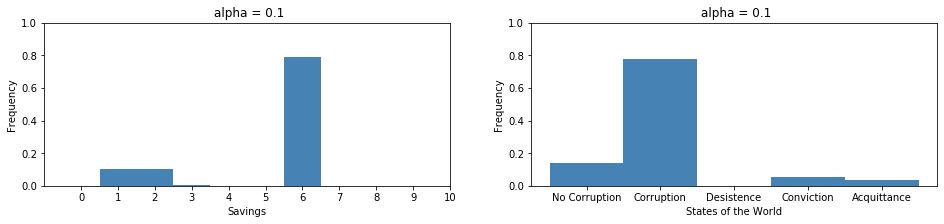

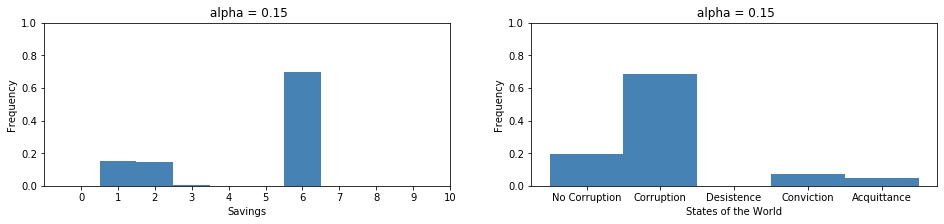

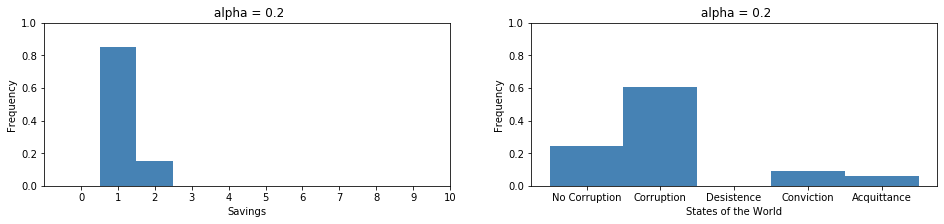

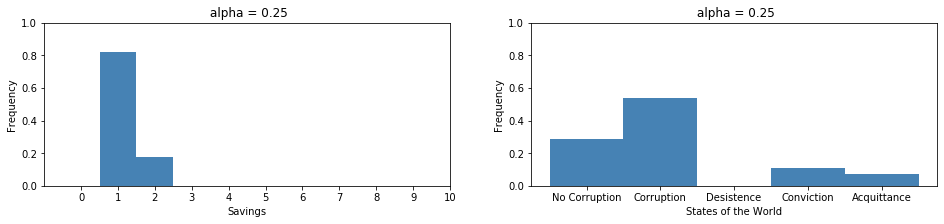

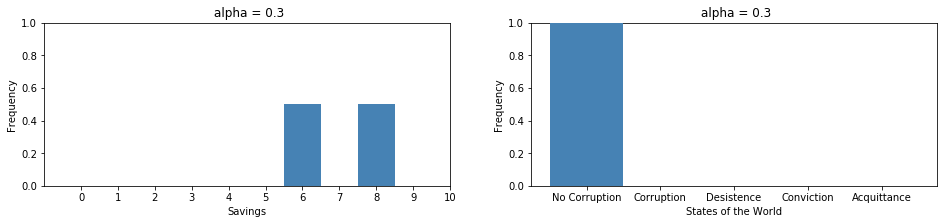

In [24]:
#Plot 1 alphas

alphas = [0.10,0.15,0.2,0.25,0.3]

for i,j in zip(alphas, range(len(alphas))):
    j = SimpleCorruption(alpha = i)
    histogram(j,' alpha = ' + str (i) )


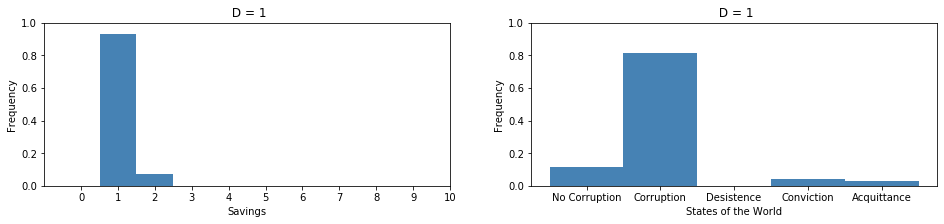

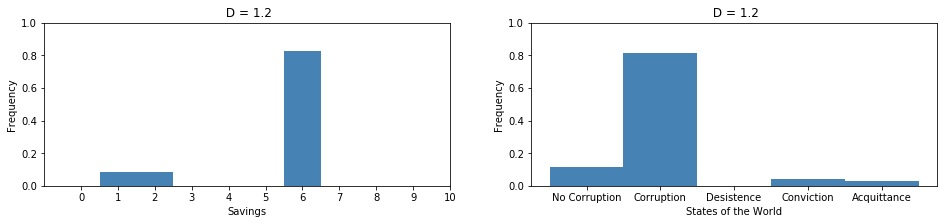

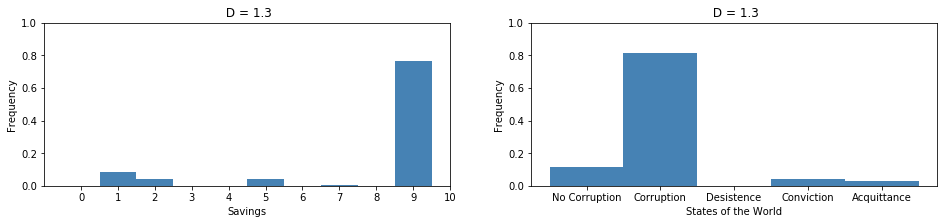

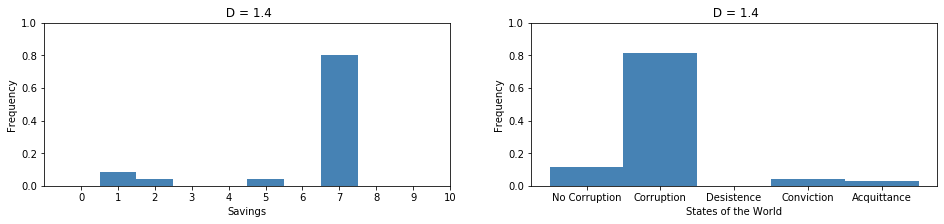

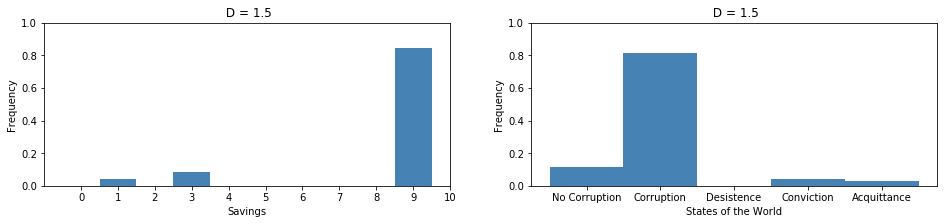

In [25]:
#Plot 2 Asset Remuneration D (Interests)

Ds = [1, 1.2 , 1.3 , 1.4 , 1.5]

for i,j in zip(Ds, range(len(Ds))):
    j = SimpleCorruption(D = i)
    histogram(j,' D = ' + str (i) )

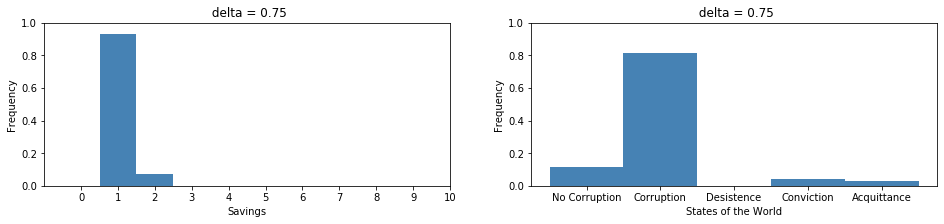

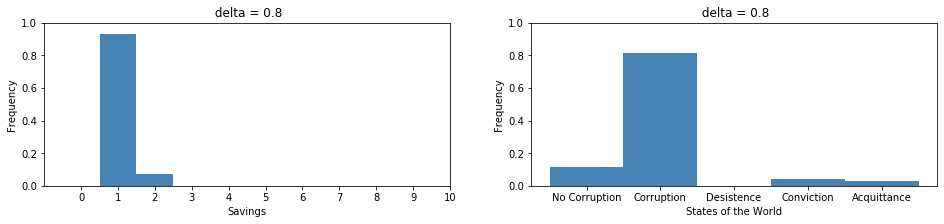

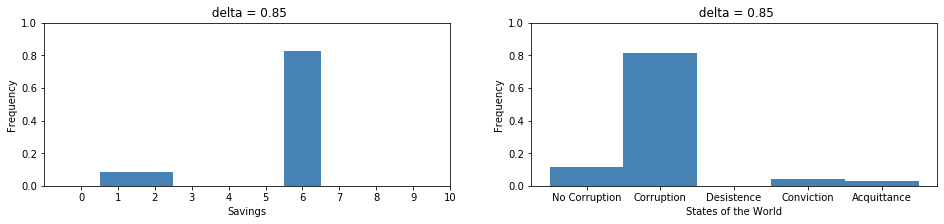

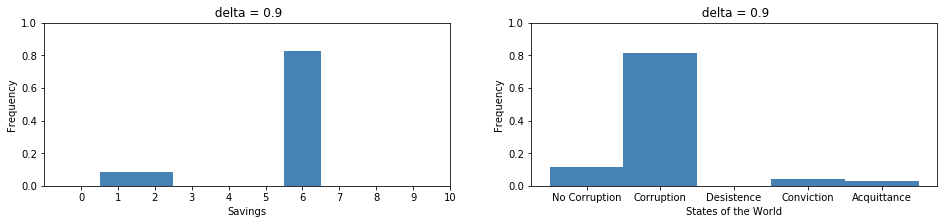

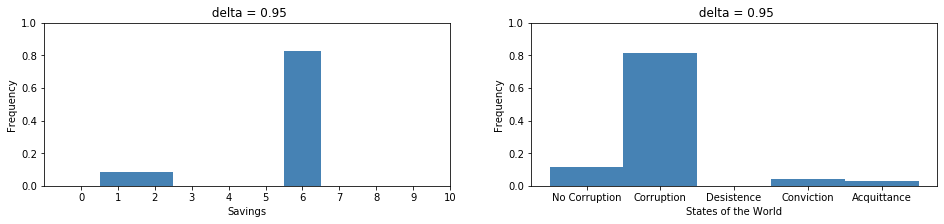

In [26]:
#Plot 3 Time discount delta

deltas = [0.75, 0.8 , 0.85 , 0.9 , 0.95]

for i,j in zip(deltas, range(len(deltas))):
    j = SimpleCorruption(delta = i)
    histogram(j,' delta = ' + str (i) )


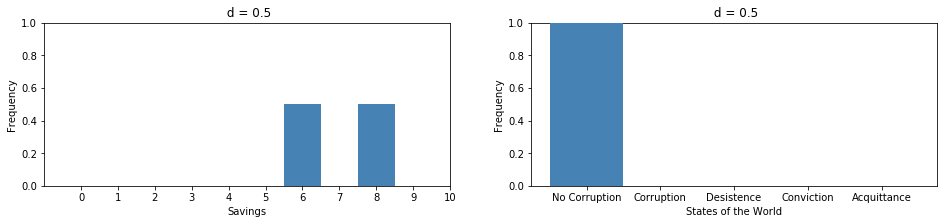

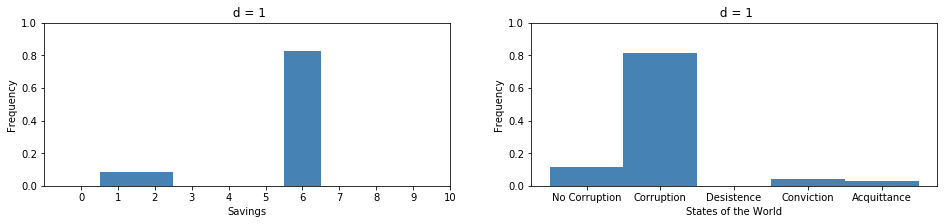

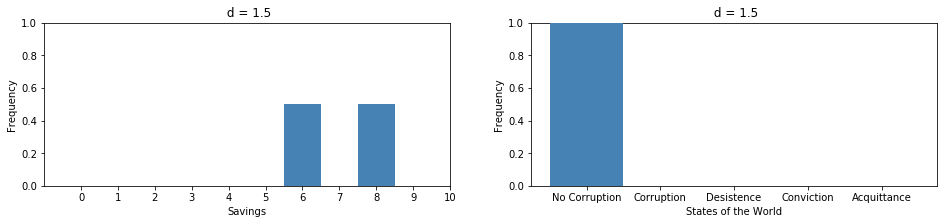

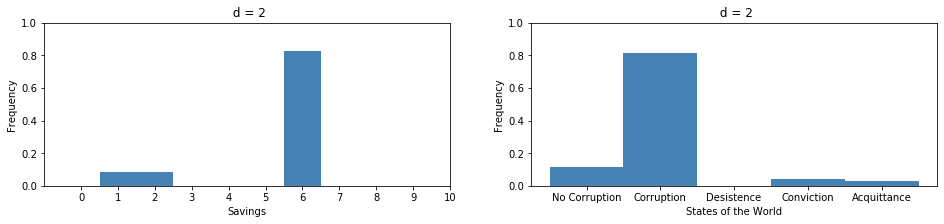

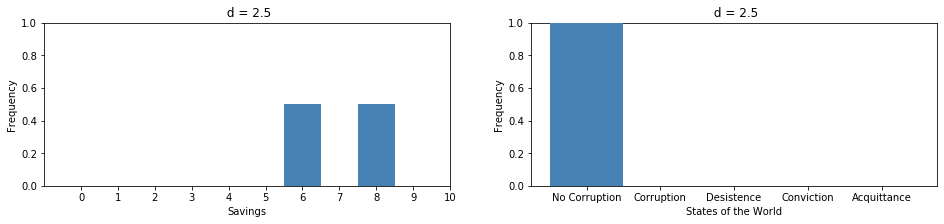

In [27]:
#Plot 4 Liability decay d

ds = [0.5, 1, 1.5 , 2 ,2.5]

for i,j in zip(ds, range(len(ds))):
    j = SimpleCorruption(d = i)
    histogram(j,' d = ' + str (i) )

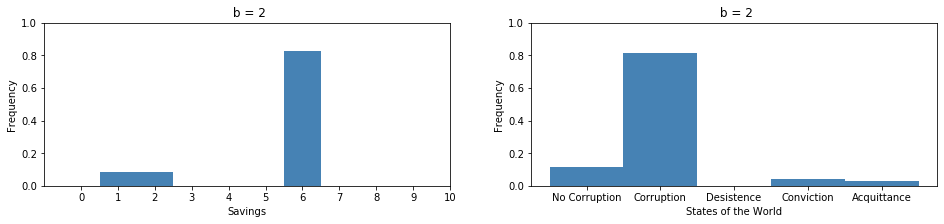

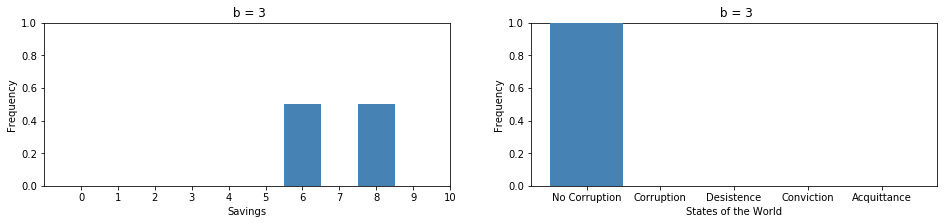

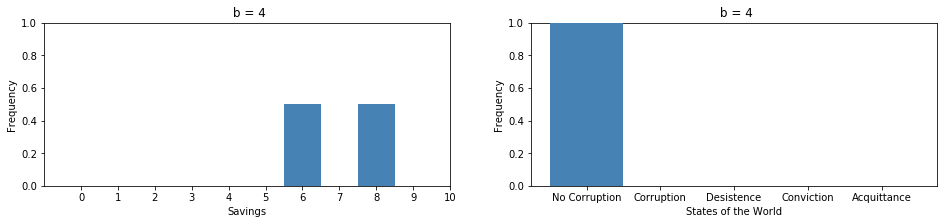

In [28]:
#Plot 5 bribe size b

bs = [2,3,4]

for i,j in zip(bs, range(len(bs))):
    j = SimpleCorruption(b = i)
    histogram(j,' b = ' + str (i) )
    

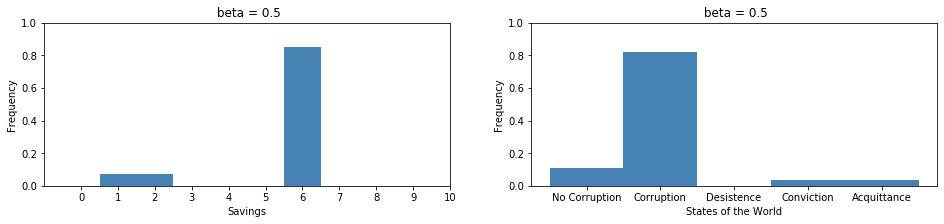

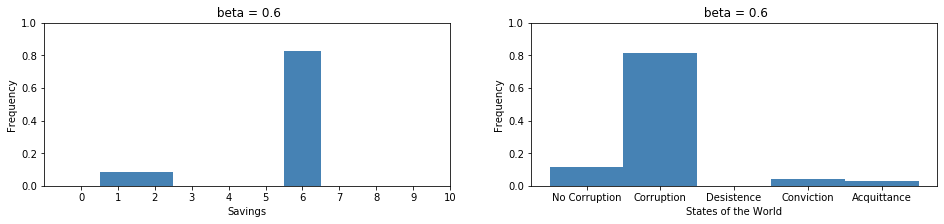

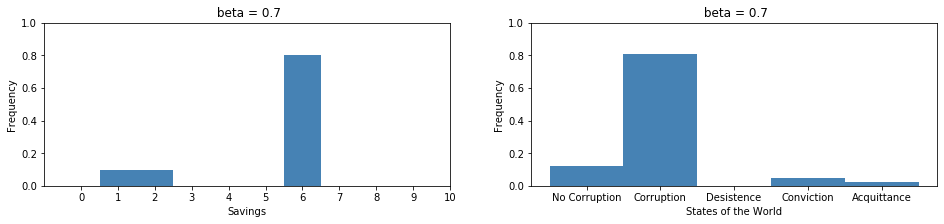

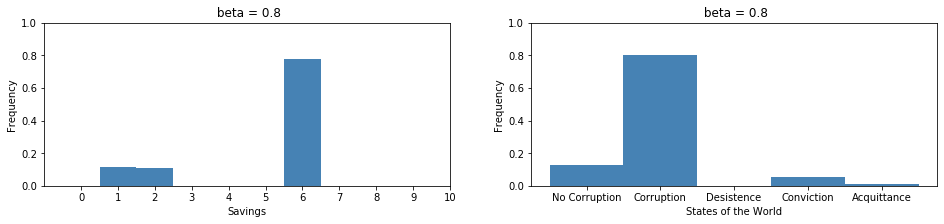

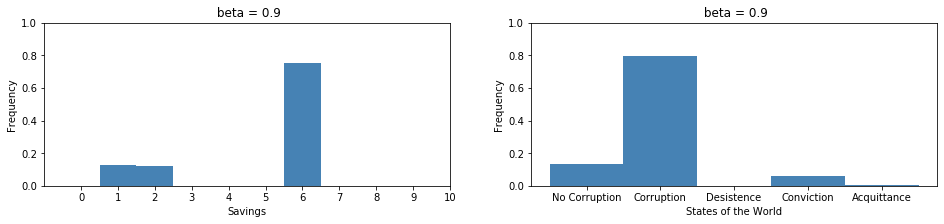

In [29]:
#Plot 6 betas

betas = [0.5,0.6,0.7,0.8,0.9]

for i,j in zip(betas, range(len(betas))):
    j = SimpleCorruption(beta = i)
    histogram(j,' beta = ' + str (i) )